# **7장 – 앙상블 학습과 랜덤 포레스트**

## 20205274 허태훈

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 투표기반 분류기

In [2]:
# 앞면 나올 확률이 0.51인 동전 1000번 던져 앞면이 더 많이 나올 확률
from scipy.stats import binom
a3 = 1-binom.cdf(1,3, 0.51)
print('a3 :', a3)
a10 = 1-binom.cdf(4,10, 0.51)
print('a10 :', a10)
a100 = 1-binom.cdf(49,100, 0.51)
print('a100 :', a100)
a1000 = 1-binom.cdf(499,1000, 0.51)
print('a1000 :', a1000)
a1000_55 = 1-binom.cdf(499,1000, 0.55)
print('a1000_55 :', a1000_55)
a10000 = 1-binom.cdf(4999,10000, 0.51)
print('a10000 :', a10000)

a3 : 0.5149980000000001
a10 : 0.6473972327703659
a100 : 0.6180787124933074
a1000 : 0.7467502275563249
a1000_55 : 0.9993191913375663
a10000 : 0.9777976478701103


In [3]:
# 세가지 분류기로 다수결 분류기 만들기.  

# make_moons 데이터 사용
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 분류기 생성
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

# 학습, 정확도 계산
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Soft Voting (간접 투표) : 각 분류기의 클래스 확률을 평균내서 가장 높은 클래스로 분류

In [4]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)  # SVC는 probability=True로 해야 predict_proba()사용할 수 있음

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 배깅 앙상블

In [5]:
# decision tree classifier 500개를 배깅 
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [6]:
# decision tree classifier 1개만 사용한 경우
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


Text(0, 0.5, '')

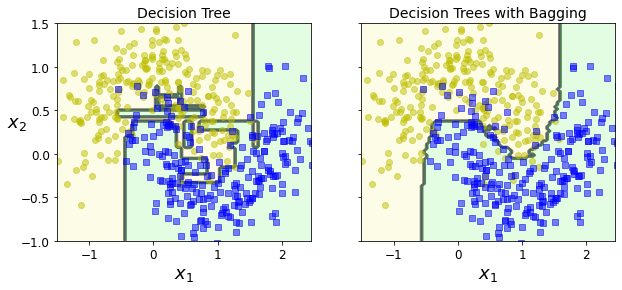

In [7]:
# 배깅과 단순 분류기와 결정경계 시각화

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")


# 랜덤 포레스트

In [8]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.912


Text(0.5, 1.0, 'Random Forest')

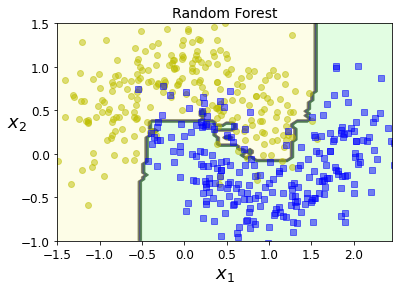

In [9]:
# 랜덤포리스트로 학습한 결정경계 시각화.  위 Bagging wiht DecisionTree 와 비슷
plot_decision_boundary(rnd_clf, X, y)
plt.title("Random Forest", fontsize=14)

In [10]:
# 특징 중요도를 알 수 있음 : feature_importances_
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf_iris = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf_iris.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf_iris.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


## OOB 평가

In [11]:
# BaggingClassifier학습과정에서 out-of-bag 샘플들 평가까지 함
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
print('Bagging oob_score_ :', bag_clf.oob_score_)

# RandomForest도 oob_score 가능
rnd_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)
rnd_clf.fit(X_train, y_train)
print('RandomForest oob_score_ :', rnd_clf.oob_score_)

Bagging oob_score_ : 0.8986666666666666
RandomForest oob_score_ : 0.904


In [12]:
# oob 평가는 test샘플 평가와 비슷한 결과 (train샘플에 대한 평가와는 매우 다름)
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
print('test샘플에 대한 정확도 :', accuracy_score(y_test, y_pred))

y_pred_tra = bag_clf.predict(X_train)
print('train샘플에 대한 정확도 :', accuracy_score(y_train, y_pred_tra))

test샘플에 대한 정확도 : 0.912
train샘플에 대한 정확도 : 1.0


In [13]:
# oob decision function을 알 수도 있음
bag_clf.oob_decision_function_[:5]

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## MNIST 데이터 특성 중요도 시각화

In [14]:
# MNIST 데이터 학습
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])


RandomForestClassifier(random_state=42)

[Text(1, 0.0, 'Not important'),
 Text(1, 0.009791489757332336, 'Very important')]

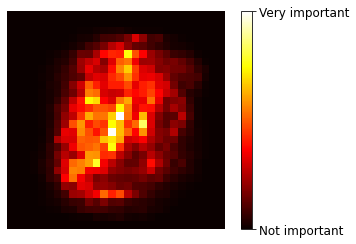

In [15]:
# 시각화
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
  

# 에이다부스트

In [16]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred_tra = ada_clf.predict(X_train)
y_pred = ada_clf.predict(X_test)
print('n_estimators=200. training샘플 정확도 :', accuracy_score(y_train, y_pred_tra), ', test샘플 정확도 :', accuracy_score(y_test, y_pred))

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred_tra = ada_clf.predict(X_train)
y_pred = ada_clf.predict(X_test)
print('n_estimaors=100. training샘플 정확도 :', accuracy_score(y_train, y_pred_tra), ', test샘플 정확도 :', accuracy_score(y_test, y_pred))

n_estimators=200. training샘플 정확도 : 0.968 , test샘플 정확도 : 0.896
n_estimaors=100. training샘플 정확도 : 0.96 , test샘플 정확도 : 0.912


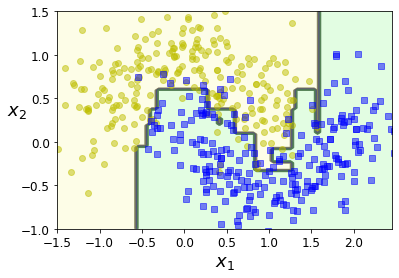

In [17]:
plot_decision_boundary(ada_clf, X, y)

# 그레이디언트 부스팅

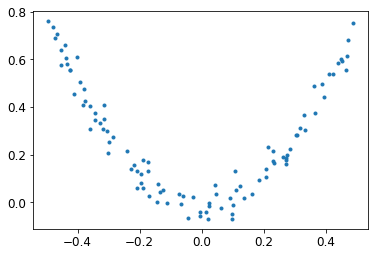

In [18]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

plt.plot(X, y, '.')

In [19]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [20]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [21]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [22]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [23]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Text(0, 0.5, '$y$')

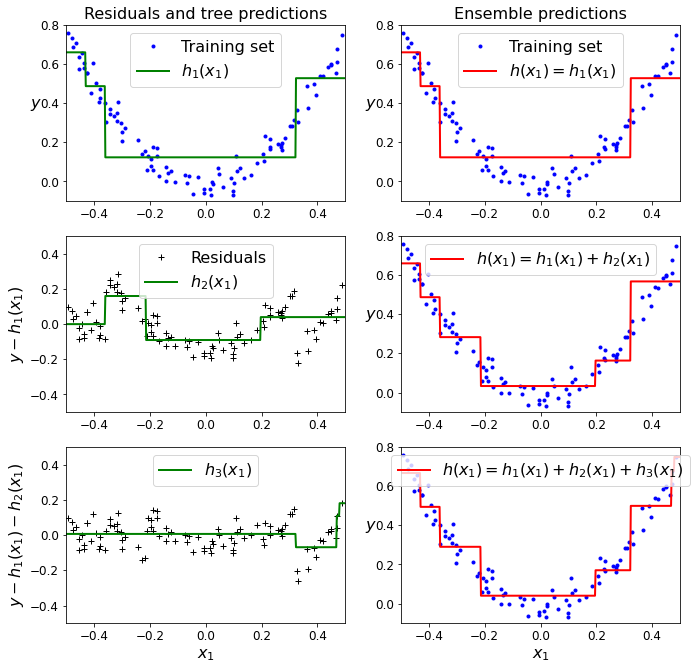

In [24]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)



In [25]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [26]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Text(0.5, 0, '$x_1$')

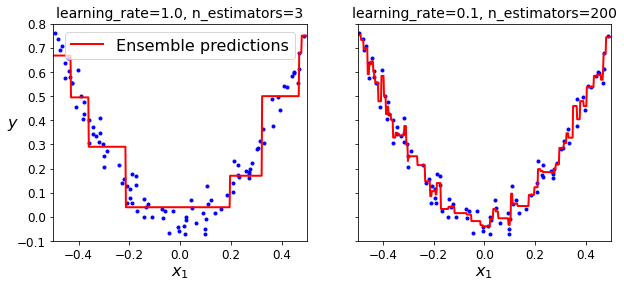

In [27]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)


# <font color=red> 과제 : GradientBoostRegressor에서 최적의 n_estimater찾기 </font>
- 아래와 같이 n_estimator에 따른 학습오차와 검증오차의 변화를 그리고
- 검증오차가 최소화되는 n_estimator값을 찾아라

In [42]:
# 과제 프로그램
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=100, random_state=42)
gbrt.fit(X_train, y_train)

class Error:
    def __init__(self, n, t, v):
        self.n_estimator = n
        self.train = t
        self.valid = v
    
    def __str__(self):
        return f'n_estimator={self.n_estimator}, training_error={self.train}, validation_error={self.valid}'
    
i = 1
errors = []
for train_pred, valid_pred in zip(gbrt.staged_predict(X_train), gbrt.staged_predict(X_val)) :  # staged_predict() : 각 단계별 predict()
  t = mean_squared_error(y_train, train_pred)
  v = mean_squared_error(y_val, valid_pred)
  errors.append(Error(i, t, v))
  i += 1

for error in errors:
    print(error)

n_estimator=1, training_error=0.05014778466687881, validation_error=0.03976434066090687
n_estimator=2, training_error=0.04230293098773478, validation_error=0.03301153878946109
n_estimator=3, training_error=0.035915798324299454, validation_error=0.027663386192027795
n_estimator=4, training_error=0.03053631767648031, validation_error=0.023337263188229852
n_estimator=5, training_error=0.026570666766095877, validation_error=0.020390590545872743
n_estimator=6, training_error=0.022857320666617883, validation_error=0.017820174421765502
n_estimator=7, training_error=0.01966190895985457, validation_error=0.015262814214454865
n_estimator=8, training_error=0.01697774409967647, validation_error=0.013228529533567415
n_estimator=9, training_error=0.014721027171218768, validation_error=0.011758450328306618
n_estimator=10, training_error=0.012919451796451074, validation_error=0.010288335529306629
n_estimator=11, training_error=0.011511761061518234, validation_error=0.009391268210618017
n_estimator=12,

In [45]:
print(min(errors, key = lambda e: e.valid))

n_estimator=56, training_error=0.0008335913229789857, validation_error=0.002712853325235463


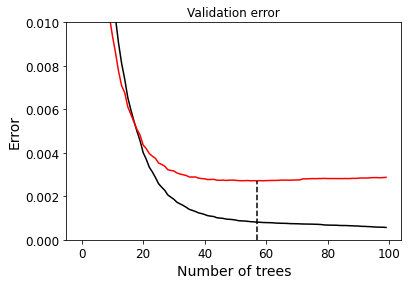

In [56]:
# 과제 프로그램
def error_plot(errors: list):
    trains = []
    valids = []
    for error in errors:
        trains.append(error.train)
        valids.append(error.valid)
    
    plt.plot(trains, color = 'black')
    plt.plot(valids, color='red')
    plt.ylim(0, 0.01)
    plt.title('Validation error')
    plt.ylabel('Error')
    plt.xlabel('Number of trees')
    error = min(errors, key = lambda e: e.valid)
    plt.axvline(x=error.n_estimator + 1, color='black', ymax=error.valid * 100, ls='--')
error_plot(errors)